<h1>Machine learning approach to forecasting<h1>

<h3>Import libraries<h3>

In [17]:
import pandas as pd
import numpy as np
import warnings
import scipy
from datetime import timedelta

<h3>Import libraries for machine learning approach<h3>

In [35]:
from statsmodels.tsa.tsatools import lagmat
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt

<h3> Import libraries for visualisation<h3>

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

<h3> Set plot style and ignore warnings, and read data into memory<h3>

In [20]:
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')
train = pd.read_csv("C:/Users/matth/webtraffic/train_1.csv")

<h3>Convert data to transacitonal and convert date field to datetime<h3>

In [78]:
#Pivots data to covert to transactional
train_flattened = pd.melt(train, id_vars='Page', var_name='date', value_name='Visits')
#Date to datetime dtype
train_flattened['date'] = train_flattened['date'].astype('datetime64[ns]')

<h3>Create a mean number of website visits per day and add day of week, day, month and year<h3>

In [153]:
mean_group = train_flattened[['Page','date','Visits']].groupby(['date'])['Visits'].mean()
times_series_means =  mean_group.reset_index(drop=False)
times_series_means['weekday'] = times_series_means['date'].dt.dayofweek
times_series_means['day'] = times_series_means['date'].dt.day
times_series_means['month'] = times_series_means['date'].dt.month
times_series_means['year'] = times_series_means['date'].dt.year
times_series_means['dayofyear'] = times_series_means['date'].dt.dayofyear

<h3>Create a function to get shifted number of visits over a set number of days. Create function to get the difference between current number of visits and previous ones<h3>

In [155]:
def lag_func(data,lag):
    lagged = data.copy()
    for c in range(1,lag+1):
        lagged["lag%d" % c] = lagged['diff'].shift(c)
    return lagged

def diff_creation(data):
    data["diff"] = np.nan
    data.ix[1:, "diff"] = (data.iloc[1:, 1].as_matrix() - data.iloc[:len(data)-1, 1].as_matrix())
    return data

<h3>Apply above functions on data for 7 days<h3>

In [175]:
df_count = diff_creation(times_series_means)

lag = 7
lagged = lag_func(df_count,lag).dropna()

last_date = lagged['date'].max()

<h3>Create a train/test split using 80% of the data to train<h3>

In [176]:
def train_test(data_lag):
    xc = ["lag%d" % i for i in range(1,lag+1)] + ['weekday'] + ['day'] + ['month'] + ['year'] + ['dayofyear']
    split = 0.80
    xt = data_lag[xc]
    yt = data_lag["diff"]        
    isplit = int(len(xt) * split)
    x_train, y_train, x_test, y_test = xt[:isplit], yt[:isplit], xt[isplit:], yt[isplit:]
    return x_train, y_train, x_test, y_test, xt, yt

x_train, y_train, x_test, y_test, xt, yt = train_test(lagged)

<h3>Train and test model with above datasets jusing two standard models and return r2, mae and rmse<h3>

In [177]:
def modelisation(x_tr, y_tr, x_ts, y_ts, xt, yt, model):
    model.fit(x_tr, y_tr)
    prediction = model.predict(x_ts)
    r2 = r2_score(y_ts.as_matrix(), prediction)
    mae = mean_absolute_error(y_ts.as_matrix(), prediction)
    rmse = sqrt(mean_squared_error(y_ts.as_matrix(), prediction))
    print ("-----------------------------------------------")
    print ("r2 with 80% of the data to train:", r2)
    print ("mae with 80% of the data to train:", mae)
    print ("rmse with 80% of the data to train:", rmse)
    print ("-----------------------------------------------")
    model.fit(xt, yt) 
    
    return model, prediction

ada =  AdaBoostRegressor(random_state = 42, learning_rate=0.01)
rfr =  RandomForestRegressor(random_state = 42)

for model in [ada, rfr]:
    print(model)
    clr, prediction  = modelisation(x_train, y_train, x_test, y_test, xt, yt, model)

AdaBoostRegressor(base_estimator=None, learning_rate=0.01, loss='linear',
         n_estimators=50, random_state=42)
-----------------------------------------------
r2 with 80% of the data to train: 0.380402528366105
mae with 80% of the data to train: 51.21838200231067
rmse with 80% of the data to train: 84.00671153144292
-----------------------------------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)
-----------------------------------------------
r2 with 80% of the data to train: 0.28807107605330495
mae with 80% of the data to train: 52.68819227121098
rmse with 80% of the data to train: 90.04870774883872
--------------------------------------

<h3>Line plot of predicted and observed values<h3>

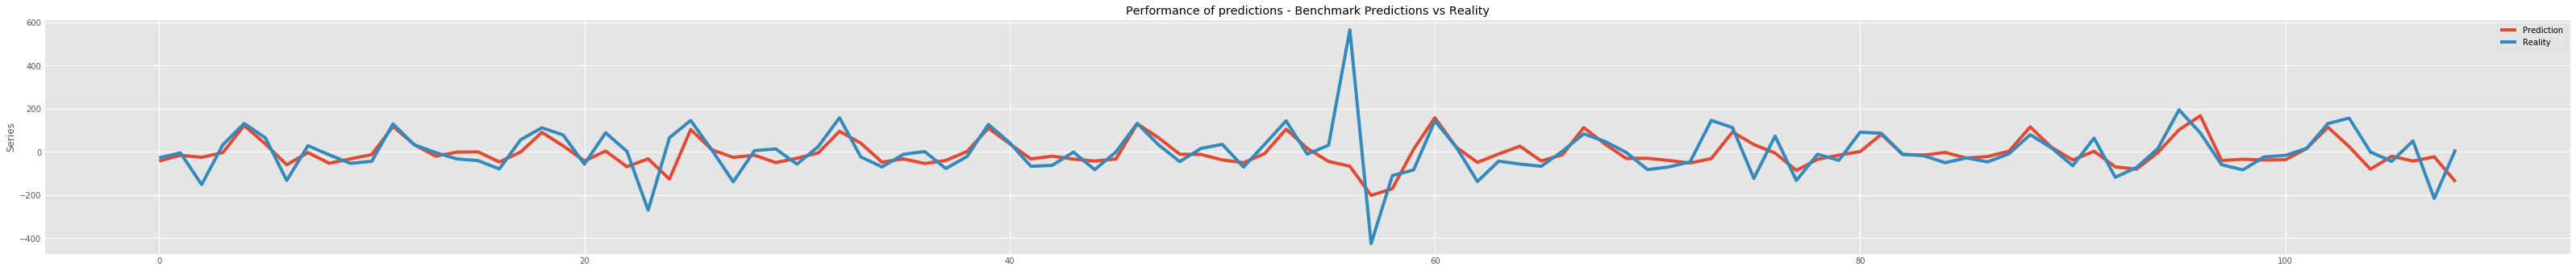

In [159]:
plt.style.use('ggplot')
plt.figure(figsize=(50, 5))
line_up, = plt.plot(prediction,label='Prediction')
line_down, = plt.plot(np.array(y_test),label='Reality')
plt.ylabel('Series')
plt.legend(handles=[line_up, line_down])
plt.title('Performance of predictions - Benchmark Predictions vs Reality')
plt.show()

<h3>Plot scatter plot of predicted values against observed<h3>

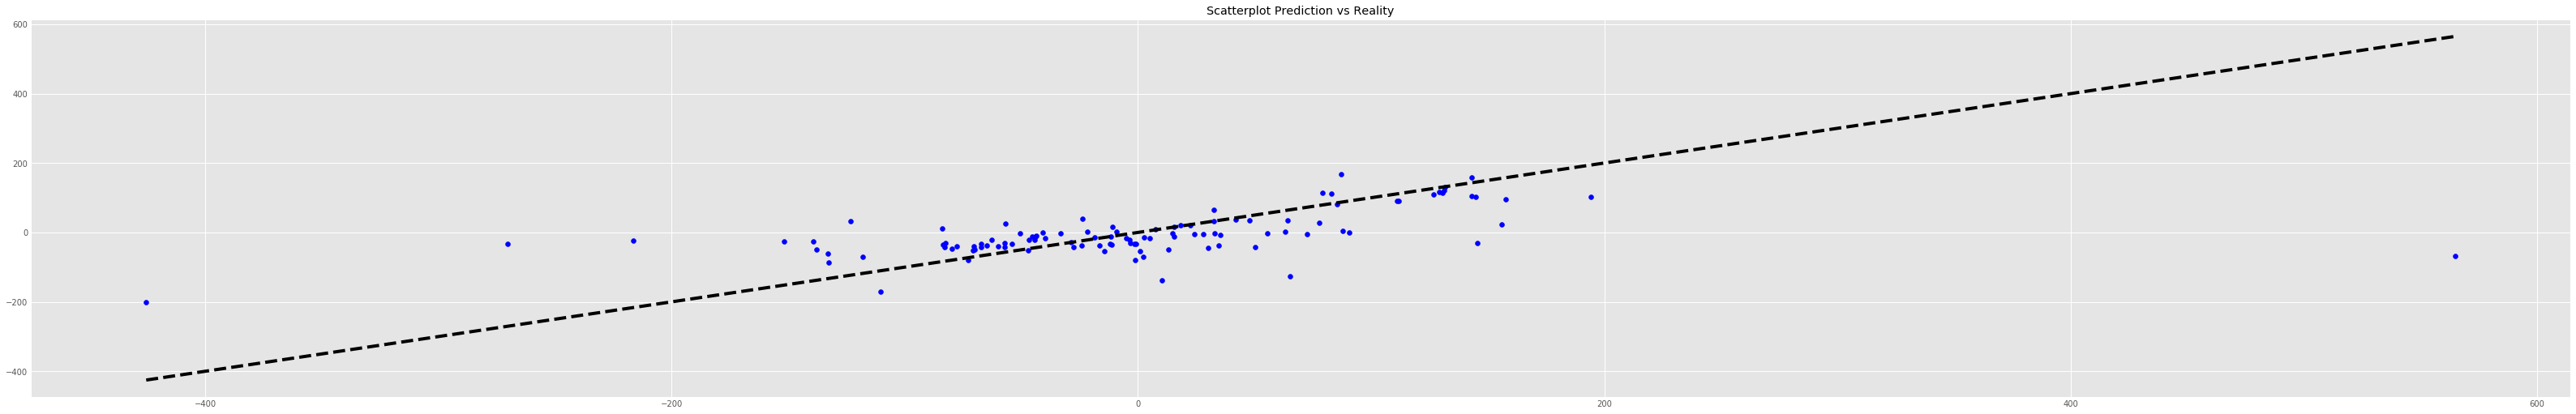

In [160]:
fig, ax = plt.subplots(figsize=(50, 8))
plt.scatter(y_test.as_matrix(), prediction, color='b')
plt.title('Scatterplot Prediction vs Reality')
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.show()

<h3>Using a function create a list of dates to predict<h3>

In [172]:
def pred_df(data,number_of_days):
    data_pred = pd.DataFrame(pd.Series(data["date"][data.shape[0]-1] + timedelta(days=1)),columns = ["date"])
    for i in range(number_of_days):
        inter = pd.DataFrame(pd.Series(data["date"][data.shape[0]-1] + timedelta(days=i+2)),columns = ["date"])
        data_pred = pd.concat([data_pred,inter]).reset_index(drop=True)
    return data_pred

data_to_pred = pred_df(df_count,30)

<h3>Predictions for coming x number of days by predicting the difference between the last day and next. Adding the predicted difference to previous day will give next days actual predicted value.<h3>

In [178]:
def initialisation(data_lag, data_pred, model, xtrain, ytrain, number_of_days):
    model.fit(xtrain, ytrain)
    
    for i in range(number_of_days-1):
        lag1 = data_lag.tail(1)["diff"].values[0]
        lag2 = data_lag.tail(1)["lag1"].values[0]
        lag3 = data_lag.tail(1)["lag2"].values[0]
        lag4 = data_lag.tail(1)["lag3"].values[0]
        lag5 = data_lag.tail(1)["lag4"].values[0]
        lag6 = data_lag.tail(1)["lag5"].values[0]
        lag7 = data_lag.tail(1)["lag6"].values[0]
        
        #Get day of week from date of data to predict
        data_pred['weekday'] = data_pred['date'].dt.dayofweek
        data_pred['day'] = data_pred['date'].dt.day
        data_pred['month'] = data_pred['date'].dt.month
        data_pred['year'] = data_pred['date'].dt.year
        data_pred['dayofyear'] = data_pred['date'].dt.dayofyear
        #Get weekday as variable
        weekday = data_pred['weekday'][0]
        day = data_pred['day'][0]
        year = data_pred['year'][0]
        month = data_pred['month'][0]
        dayofyear = data_pred['dayofyear'][0]
        
        data = {'lag1': lag1,
                'lag2': lag2,
                'lag3': lag3,
                'lag4': lag4,
                'lag5': lag5,
                'lag6': lag6,
                'lag7': lag7,
               'weekday': weekday,
               'day': day,
               'month':  month,
               'year': year,
               'dayofyear': dayofyear}
        
        to_predict = pd.DataFrame(data=data, index=[0])

        prediction = pd.DataFrame(model.predict(to_predict),columns = ['diff'])

        last_predict = data_lag["Visits"][data_lag.shape[0]-1] + prediction.values[0][0]
        
        data_lag = pd.concat([data_lag, prediction.join(data_pred["date"]).join(to_predict)]).reset_index(drop=True)
        data_lag["Visits"][data_lag.shape[0]-1] = last_predict
        data_pred = data_pred[data_pred["date"]>data_pred["date"][0]].reset_index(drop=True)
    return data_lag

model_fin = AdaBoostRegressor(random_state = 42, learning_rate=0.01)

lagged = initialisation(lagged, data_to_pred, model_fin, xt, yt, 30)

<h3>Plot of observed data and predicted data points<h3>

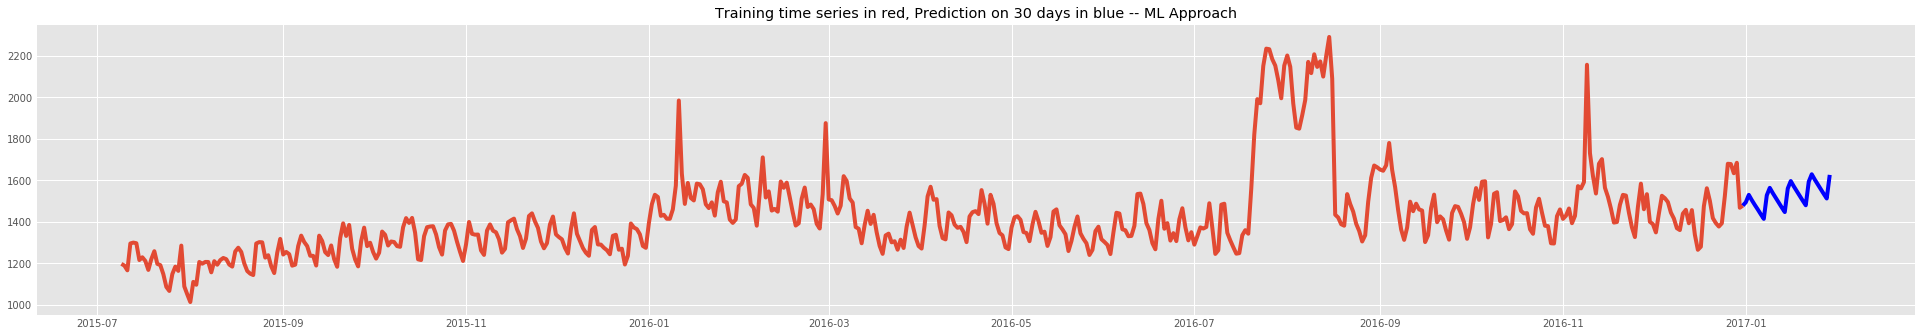

In [179]:
df_lagged = lagged[['Visits','date']]
df_train = df_lagged[df_lagged['date'] <= last_date]
df_pred = df_lagged[df_lagged['date'] >= last_date]
plt.style.use('ggplot')
plt.figure(figsize=(30, 5))
plt.plot(df_train.date,df_train.Visits)
plt.plot(df_pred.date,df_pred.Visits,color='b')
plt.title('Training time series in red, Prediction on 30 days in blue -- ML Approach')
plt.show()